# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [3]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
# why is user score stored as string?
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [7]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         5332 non-null float64
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(7), int64(1), object(5)
memory usage: 1.2+ MB


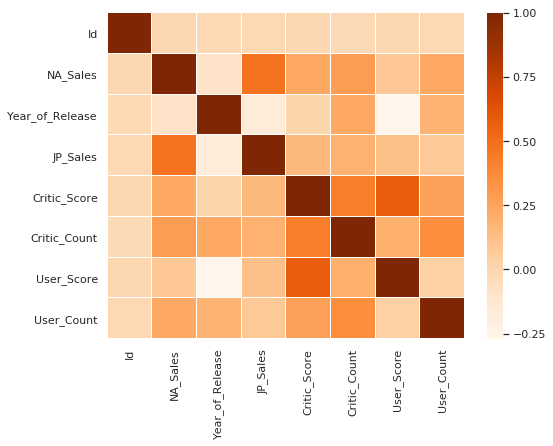

In [8]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), cmap="Oranges", linewidths=0.1);

As the columns `Publisher` and `Developer` contain way too many values and also doesn't seem to add any reasonable value to our prediction, let's drop them. Together with the `Id` that's not needed either.

In [9]:
df = df.drop(['Id', 'Publisher', 'Developer', 'Year_of_Release', 'User_Score'], axis=1)

### 2. Preprocessing the Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11703 non-null float64
Platform        11703 non-null object
Genre           11701 non-null object
JP_Sales        11703 non-null float64
Critic_Score    5697 non-null float64
Critic_Count    5697 non-null float64
User_Count      5332 non-null float64
Rating          6978 non-null object
dtypes: float64(5), object(3)
memory usage: 731.5+ KB


The problem is we have tons of missing values! What to do? Let's walk through each of these features:

**2.1. Handling `Rating` column**

In [11]:
df.Rating.unique()

array(['E', nan, 'T', 'M', 'E10+', 'EC', 'RP', 'K-A'], dtype=object)

In [12]:
df.Rating.value_counts()

E       2791
T       2069
M       1109
E10+    1000
EC         5
RP         2
K-A        2
Name: Rating, dtype: int64

According to [Wikipedia](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) ....

In [13]:
def value_replacement(col, to_replace, new_value):
    col.replace(to_replace, new_value, inplace=True)

In [14]:
value_replacement(df.Rating, to_replace='EC', new_value='E')
value_replacement(df.Rating, to_replace='K-A', new_value='E')
value_replacement(df.Rating, to_replace='RP', new_value='None')
value_replacement(df.Rating, to_replace=np.nan, new_value='None')

df.Rating.value_counts()

None    4727
E       2798
T       2069
M       1109
E10+    1000
Name: Rating, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11703 non-null float64
Platform        11703 non-null object
Genre           11701 non-null object
JP_Sales        11703 non-null float64
Critic_Score    5697 non-null float64
Critic_Count    5697 non-null float64
User_Count      5332 non-null float64
Rating          11703 non-null object
dtypes: float64(5), object(3)
memory usage: 731.5+ KB


**2.2. Handling `Year_of_Release` column**

In [16]:
#df1 = df[df['Year_of_Release'].isna()]
#df1.tail(10)

In [17]:
#df.Year_of_Release.max()

In [18]:
#df.Year_of_Release.describe()

In [19]:
#df.Year_of_Release.hist(bins=20);

It might be reasonable to bin the years into periods of roughly 5 years and when doing this, also bin the NaN values into *unknown*.

In [77]:
# bin the year_of_release into periods_of_release
bins = [1980, 1995, 2000, 2005, 2010, 2015, 2017]
labels = ['Before 1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015', '2015-2017']
df['Periods_of_Release'] = pd.cut(df['Year_of_Release'], bins=bins, labels=labels)

# create another category for the unknown release date
df['Periods_of_Release'].replace(to_replace=np.nan, value='Unknown', inplace=True)

In [20]:
#df.Periods_of_Release.unique()

In [21]:
#df.Periods_of_Release.value_counts()

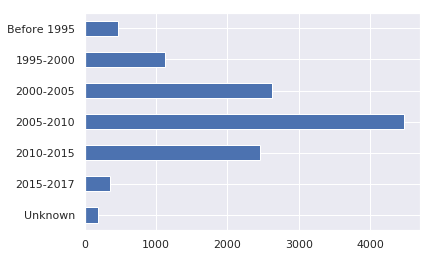

In [80]:
# visualize the distribution of categories
order = ['Unknown', '2015-2017', '2010-2015', '2005-2010',  '2000-2005','1995-2000', 'Before 1995']
df.Periods_of_Release.value_counts().loc[order].plot(kind='barh');

In [23]:
# drop the original year related column
#df = df.drop(['Year_of_Release'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11703 non-null float64
Platform        11703 non-null object
Genre           11701 non-null object
JP_Sales        11703 non-null float64
Critic_Score    5697 non-null float64
Critic_Count    5697 non-null float64
User_Count      5332 non-null float64
Rating          11703 non-null object
dtypes: float64(5), object(3)
memory usage: 731.5+ KB


**2.3. Handling `User_Score` column**

In [24]:
#df.User_Score.isna().sum()

In [25]:
#df.info()

In [26]:
#red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
#df.boxplot(column='User_Score', by='Platform', vert=False, flierprops=red_square, figsize=(16,8));

In [27]:
# the groupby + transform syntax maps the groupwise mean to the index of the original dataframe
#df['User_Score'] = df['User_Score'].fillna(df.groupby(['Platform'])['User_Score'].transform('mean'))
#df.info()

**2.4. Handling `Critic_Score` column**

In [28]:
df.Critic_Score.isna().sum()

6006

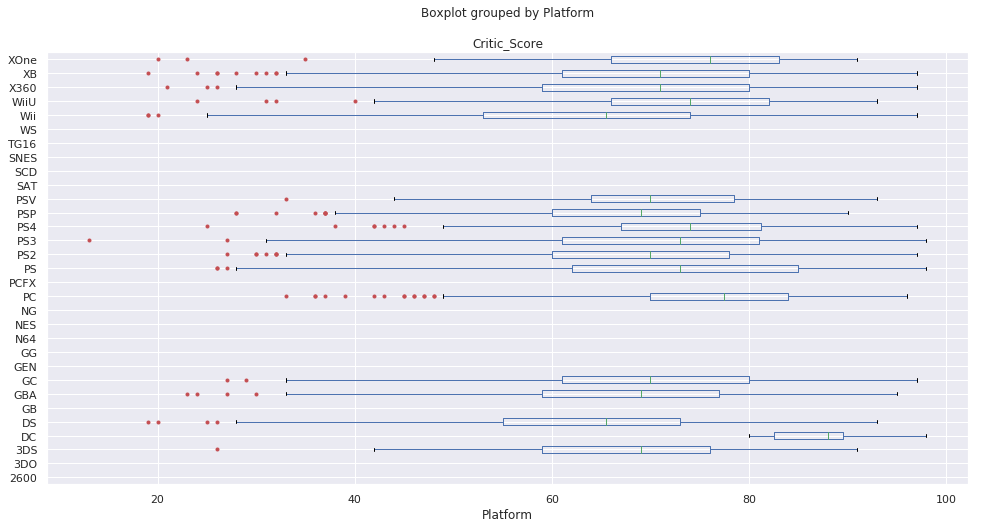

In [29]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df.boxplot(column='Critic_Score', by='Platform', vert=False, flierprops=red_square, figsize=(16,8));

In [30]:
df['Critic_Score'] = df['Critic_Score'].fillna(df.groupby(['Platform'])['Critic_Score'].transform('mean'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11703 non-null float64
Platform        11703 non-null object
Genre           11701 non-null object
JP_Sales        11703 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    5697 non-null float64
User_Count      5332 non-null float64
Rating          11703 non-null object
dtypes: float64(5), object(3)
memory usage: 731.5+ KB


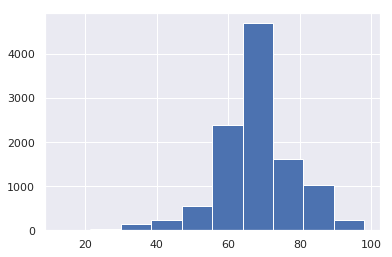

In [31]:
df.Critic_Score.hist();

.....

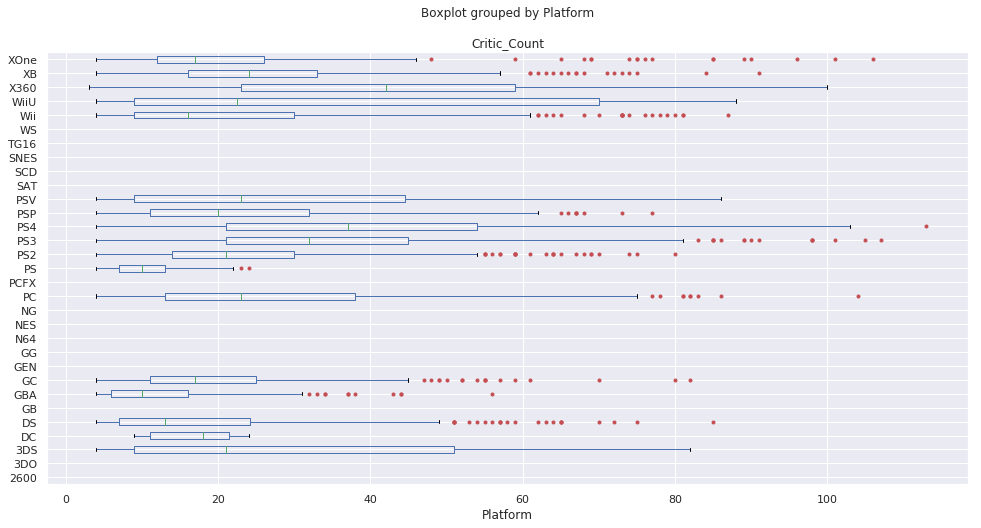

In [32]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df.boxplot(column='Critic_Count', by='Platform', vert=False, flierprops=red_square, figsize=(16,8));

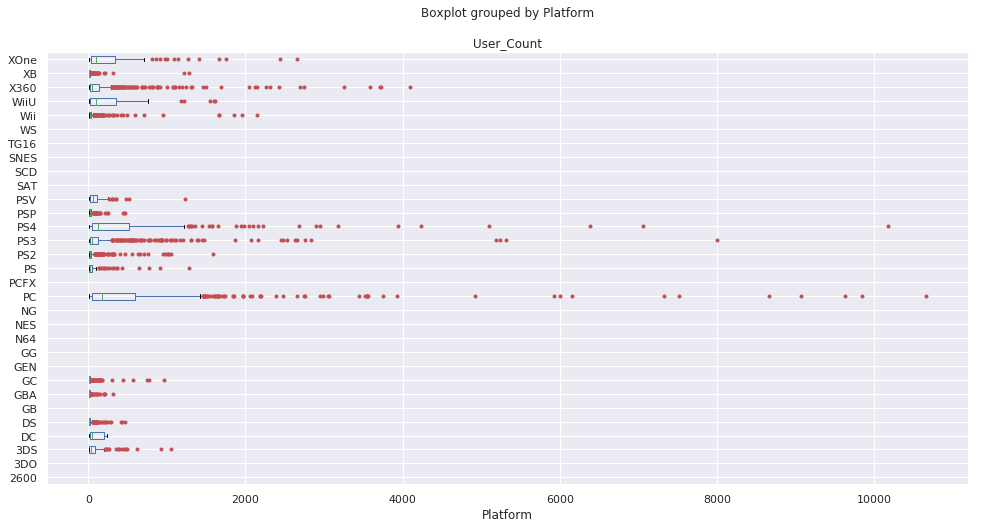

In [33]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df.boxplot(column='User_Count', by='Platform', vert=False, flierprops=red_square, figsize=(16,8));

In [34]:
df['Critic_Count'] = df['Critic_Count'].fillna(df.groupby(['Platform'])['Critic_Count'].transform('mean'))
df['User_Count']   = df['User_Count'].fillna(df.groupby(['Platform'])['User_Count'].transform('mean'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11703 non-null float64
Platform        11703 non-null object
Genre           11701 non-null object
JP_Sales        11703 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    10930 non-null float64
User_Count      10930 non-null float64
Rating          11703 non-null object
dtypes: float64(5), object(3)
memory usage: 731.5+ KB


**2.5. Handling `Genre` column**

In [35]:
df = df.dropna(subset=['Genre'], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        11701 non-null float64
Platform        11701 non-null object
Genre           11701 non-null object
JP_Sales        11701 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    10930 non-null float64
User_Count      10930 non-null float64
Rating          11701 non-null object
dtypes: float64(5), object(3)
memory usage: 822.7+ KB


**2.6. Handling `Platform` column**

In [93]:
#df.Platform.value_counts()

In [94]:
#df.drop(df[(df.Platform.value_counts() < 100)].index, axis=0, inplace=True)
#df = df.groupby('Platform').filter(lambda x: len(x) > 100)
#df.Platform.value_counts()

In [36]:
df = df.dropna()

## 3. Machine Learning

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10930 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        10930 non-null float64
Platform        10930 non-null object
Genre           10930 non-null object
JP_Sales        10930 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    10930 non-null float64
User_Count      10930 non-null float64
Rating          10930 non-null object
dtypes: float64(5), object(3)
memory usage: 768.5+ KB


*Preparing Target & Features*

In [38]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10930 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        10930 non-null float64
Platform        10930 non-null object
Genre           10930 non-null object
JP_Sales        10930 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    10930 non-null float64
User_Count      10930 non-null float64
Rating          10930 non-null object
dtypes: float64(5), object(3)
memory usage: 768.5+ KB


In [40]:
# convert string values in object columns into categorical values
df['Platform'] = df['Platform'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Rating'] = df['Rating'].astype('category')
#df['Periods_of_Release'] = df['Periods_of_Release'].astype('category')
#df['Platform_Groups'] = df['Platform_Groups'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10930 entries, 0 to 11702
Data columns (total 8 columns):
NA_Sales        10930 non-null float64
Platform        10930 non-null category
Genre           10930 non-null category
JP_Sales        10930 non-null float64
Critic_Score    10930 non-null float64
Critic_Count    10930 non-null float64
User_Count      10930 non-null float64
Rating          10930 non-null category
dtypes: category(3), float64(5)
memory usage: 545.7 KB


In [41]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [42]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [43]:
# scale data
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test  = sc.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


*XGBoost*

In [44]:
# create a baseline
booster = xgb.XGBRegressor()

In [50]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [45]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, 
                           max_depth=3, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [46]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.4195
r2: 0.4887


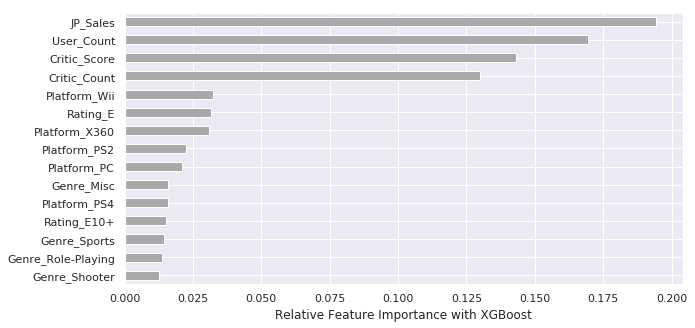

In [47]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');